In [1]:
import numpy as np
import pandas as pd
import os
import scipy 
from scipy.interpolate import RegularGridInterpolator

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
mod_outpath = '/home/birniece/Documents/data/UTAH_FORGE/ClairesVMods'
rec_outpath = '/home/birniece/Documents/data/UTAH_FORGE/ReceiverLocations'

# READ Velocity Model

In [3]:
SLB_vmod = pd.read_excel('/home/birniece/Documents/data/UTAH_FORGE/Seismic_Velocity_Model_FORGE_Site.xlsx', 
                          header=0, 
                        )
SLB_vmod.head()

,Easting[km],Northing[km],x[km],y[km],z[km],Vp[km/s],Vs[km/s],Vp/Vs
0,332.800507,4260.690918,0.000,0.0,0.0,1.0,0.577,1.733
1,332.925507,4260.690918,0.125,0.0,0.0,1.0,0.577,1.733
2,333.050507,4260.690918,0.250,0.0,0.0,1.0,0.577,1.733
3,333.175507,4260.690918,0.375,0.0,0.0,1.0,0.577,1.733
4,333.300507,4260.690918,0.500,0.0,0.0,1.0,0.577,1.733


In [4]:
SLB_vmod_crp = SLB_vmod[SLB_vmod[' z[km]'] < 2.0]
SLB_vmod_crp = SLB_vmod_crp[SLB_vmod_crp[' x[km]'] < 3.25]
SLB_vmod_crp = SLB_vmod_crp[SLB_vmod_crp[' x[km]'] > 2.]
SLB_vmod_crp = SLB_vmod_crp[SLB_vmod_crp[' y[km]'] < 3.25]
SLB_vmod_crp = SLB_vmod_crp[SLB_vmod_crp[' y[km]'] > 2.]
len(SLB_vmod_crp)

1296

In [5]:
x = SLB_vmod_crp[' x[km]'].values
y = SLB_vmod_crp[' y[km]'].values
z = SLB_vmod_crp[' z[km]'].values

nx = len(np.unique(x))
ny = len(np.unique(y))
nz = len(np.unique(z))
print(nx,ny,nz)

dx_o = x[1]-x[0]
dy_o = np.unique(y)[1]-np.unique(y)[0]
dz_o = np.unique(z)[1]-np.unique(z)[0]
print(dx_o,dy_o,dz_o)

vp_flat = SLB_vmod_crp[' Vp[km/s]'].values
vs_flat = SLB_vmod_crp[' Vs[km/s]'].values

9 9 16
0.125 0.125 0.125


(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='y samples', ylabel='z samples'>,
  <Axes: xlabel='x samples'>,
  <Axes: ylabel='x samples'>))

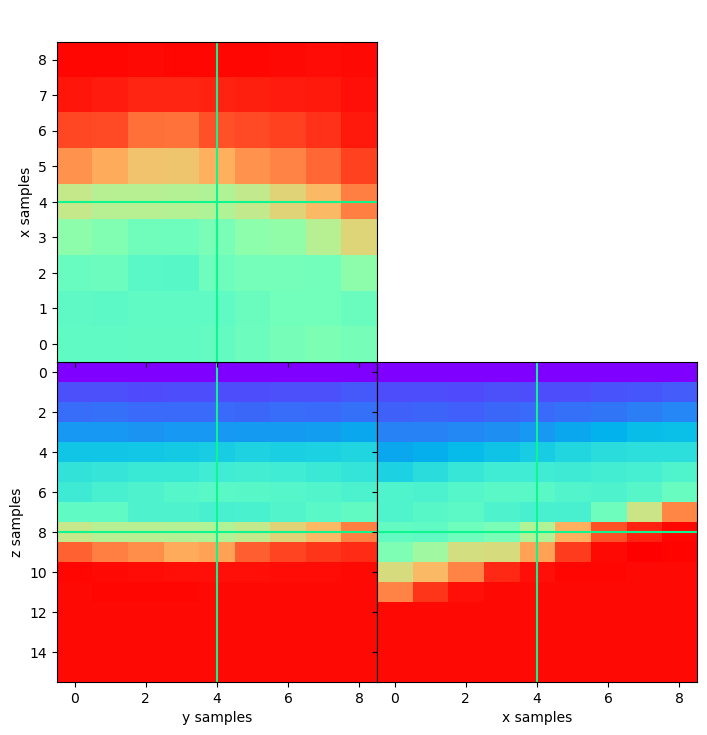

In [6]:
from pyfrac.visualisation.plotting_support import explode_volume

vp_3D = vp_flat.reshape([nz, ny, nx])
vs_3D = vs_flat.reshape([nz, ny, nx])

explode_volume(vp_3D, 
               t=nz//2, 
               x=ny//2, 
               y=nx//2,
               cmap='rainbow',      
               clipval = [np.min(vp_3D), np.max(vp_3D)],
               labels=( '[z]', '[x]', '[y]',),
               tlabel='z', xlabel='y', ylabel='x',
               title=' ',
               )

# MAKE MODELS

In [7]:
# Model parameters
dx = dy = dz = 2.

xmax = 1760
ymax = 1920
zmax = 1600

nx_mod = int(xmax//dx)
ny_mod = int(ymax//dy)
nz_mod = int(zmax//dz)
print(nx_mod,ny_mod,nz_mod)
# Checking for nxyz
print(nx_mod/10,ny_mod/10,nz_mod/10)
# Checking for snapshots
print(nx_mod/10/4,ny_mod/10/4,nz_mod/10/4)

880 960 800
88.0 96.0 80.0
22.0 24.0 20.0


## Homo model from average velocity 


## Pancake

In [8]:
z_o = np.unique(z)*1000

x_pancake = np.arange(min(x)*1000,max(x)*1000,dx)
y_pancake = np.arange(min(y)*1000,max(y)*1000,dy)
z_pancake = np.arange(min(z)*1000,max(z)*1000,dz)
print(len(x_pancake))

nx_pancake = len(x_pancake)
ny_pancake = len(y_pancake)
nz_pancake = len(z_pancake)


500


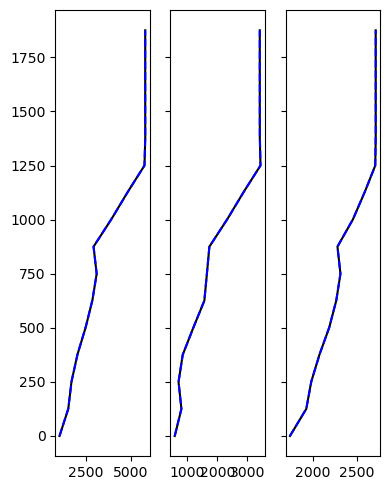

In [9]:
vp_log_o = vp_3D[:,ny//2,nx//2] *1000
vs_log_o = vs_3D[:,ny//2,nx//2] *1000
rho_log_o = (0.31 * vp_log_o**0.25)  *1000 # kg/m**3

f_vp = scipy.interpolate.interp1d(z_o, vp_log_o, kind='linear')#, kind='previous')
f_vs = scipy.interpolate.interp1d(z_o, vs_log_o, kind='linear')#, kind='previous')
f_rho = scipy.interpolate.interp1d(z_o, rho_log_o, kind='linear')#, kind='previous')
vp_log = f_vp(z_pancake)
vs_log = f_vs(z_pancake)
rho_log = f_rho(z_pancake)

fig,axs = plt.subplots(1,3,figsize=[4,5], sharey=True)
axs[0].plot(vp_log_o, z_o,'k')
axs[0].plot(vp_log, z_pancake, '--b')
axs[1].plot(vs_log_o, z_o,'k')
axs[1].plot(vs_log, z_pancake, '--b')
axs[2].plot(rho_log_o, z_o,'k')
axs[2].plot(rho_log, z_pancake, '--b')
fig.tight_layout()

In [10]:
# Expand to 3D
vp_pancake = np.expand_dims(vp_log, axis=[1,2])
vp_pancake = vp_pancake.repeat(nx_pancake,axis=2).repeat(ny_pancake,axis=1)
vs_pancake = np.expand_dims(vs_log, axis=[1,2])
vs_pancake = vs_pancake.repeat(nx_pancake,axis=2).repeat(ny_pancake,axis=1)
rho_pancake = np.expand_dims(rho_log, axis=[1,2])
rho_pancake = rho_pancake.repeat(nx_pancake,axis=2).repeat(ny_pancake,axis=1)

In [20]:
np.max(rho_pancake)

2707.8801936503182

(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='y samples', ylabel='z samples'>,
  <Axes: xlabel='x samples'>,
  <Axes: ylabel='x samples'>))

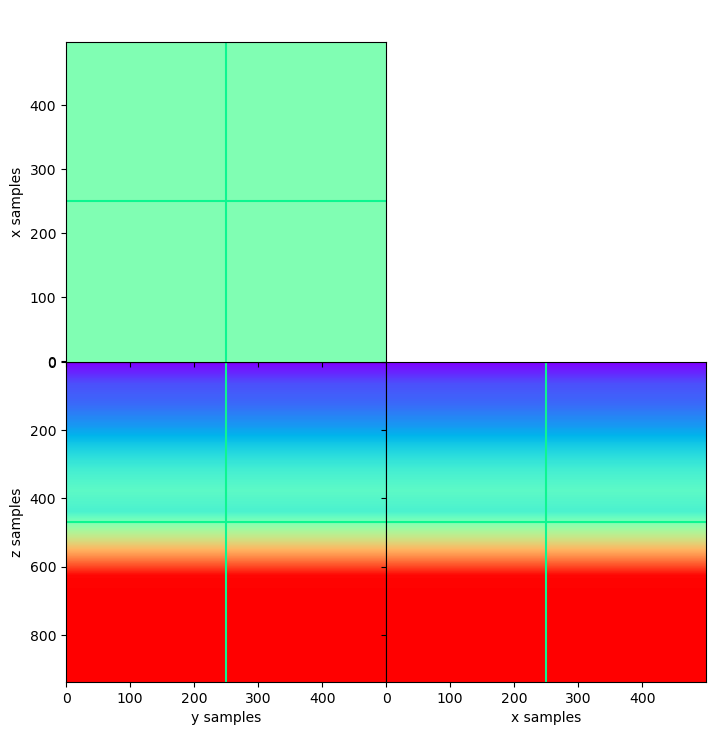

In [12]:
explode_volume(vp_pancake, 
               t=vp_pancake.shape[0]//2, 
               x=vp_pancake.shape[1]//2, 
               y=vp_pancake.shape[2]//2,
               cmap='rainbow',      
               clipval = [np.min(vp_pancake), np.max(vp_pancake)],
               labels=( '[z]', '[x]', '[y]',),
               tlabel='z', xlabel='y', ylabel='x',
               title=' ',
               )

(<Figure size 800x800 with 3 Axes>,
 (<Axes: xlabel='y samples', ylabel='z samples'>,
  <Axes: xlabel='x samples'>,
  <Axes: ylabel='x samples'>))

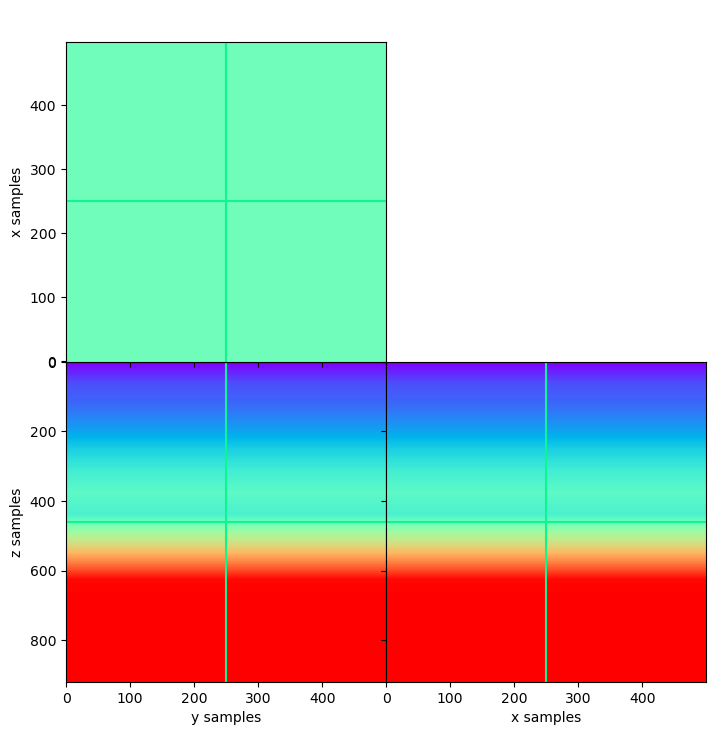

In [13]:
# Trim model slightly [z,y,x]
vp_pancake = vp_pancake[:460*2,:600,:600]
vs_pancake = vs_pancake[:460*2,:600,:600]
rho_pancake = rho_pancake[:460*2,:600,:600]

explode_volume(vp_pancake, 
               t=vp_pancake.shape[0]//2, 
               x=vp_pancake.shape[1]//2, 
               y=vp_pancake.shape[2]//2,
               cmap='rainbow',      
               clipval = [np.min(vp_pancake), np.max(vp_pancake)],
               labels=( '[z]', '[x]', '[y]',),
               tlabel='z', xlabel='y', ylabel='x',
               title=' ',
               )

In [14]:
vp_pancake.shape

(920, 500, 500)

In [15]:
# Transpose to [x,z,y] and save
# Write as binary
expname = 'UtahFORGE_lateralhomo_2m'
outpath = os.path.join(mod_outpath,'lateralhomo/')
os.makedirs(outpath, exist_ok=True)
vp_pancake.transpose([2,0,1]).astype(np.float32).tofile(os.path.join(outpath,'%s.vp'%expname),format='<f')
vs_pancake.transpose([2,0,1]).astype(np.float32).tofile(os.path.join(outpath,'%s.vs'%expname),format='<f')
rho_pancake.transpose([2,0,1]).astype(np.float32).tofile(os.path.join(outpath,'%s.rho'%expname),format='<f')

## CROPPED MODEL - Resampled

# ACQUISITIONS

1000.0
(3, 169)


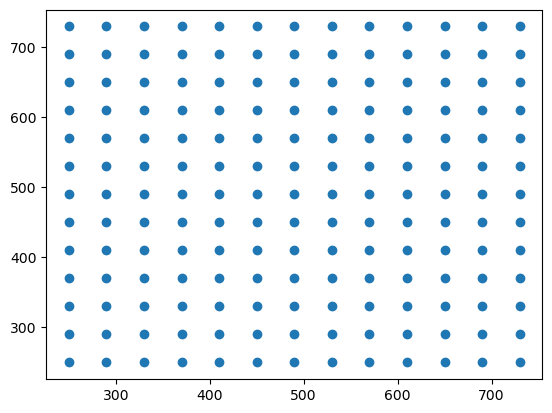

In [21]:
# RECEIVERS
xmaxpoint = (vp_pancake.shape[2])*dx
ymaxpoint = (vp_pancake.shape[1])*dy
print(xmaxpoint)
grid_rx_locs = np.arange(250, xmaxpoint-250, 40)
grid_ry_locs = np.arange(250, ymaxpoint-250, 40)

rx, ry, rz = np.meshgrid(grid_rx_locs,
                         grid_ry_locs,
                         dz*41) 
recs = np.vstack((rx.flatten(), rz.flatten(), ry.flatten()))
nr = recs.shape[1]

plt.scatter(rx,ry)
print(recs.shape)

np.savetxt(os.path.join(rec_outpath,'UtahFORGE_griddedrecs_2m.dat'),
           recs.T.astype(np.float32), 
           fmt='%.4f')

In [17]:
# # Source 
# sx, sy, sz = 850, 860, 1300
# td = 1e-6  # ignition time
# fc = 20  # central frequency
# amp = 1.  # amplitude
# string_list = [str(i) for i in [sx, sz, sy, td, fc, amp]]
# src_string = '\t'.join(string_list)
# print(src_string)
# text_file = open(os.path.join(outpath,'sources.dat'), "wt")
# text_file.writelines(src_string)
# text_file.close()